Aprendizaje Automático - Práctica 2
Autores: RICARDO ANTONIO PAZOS VALERO - 100472303 / VICENTE ANTONIO BARBATO - 10043114

# K-Means
---
Programamos el algoritmo K-Means para comparar nuestra implementación con la implementación de sklearn

In [21]:
# Importamos
import numpy as np
import time

# Desarrollamos nuestro propio K-Means
def distance(p1, p2, metric='manhattan'):
    """Función auxiliar que calcula la distancia entre dos puntos"""
    if metric == 'manhattan':
        return np.sum(np.abs(p1 - p2))
    elif metric == 'euclidean':
        return np.sqrt(np.sum((p1 - p2)**2))
    elif metric == 'minkowski':
        p = 3
        return np.sum(np.abs(p1 - p2)**p)**(1/p)

def myKMeans(X, clusters, k, metric, max_iter=100, tol=1e-4):
    """Nuestra función KMeans"""
    for _ in range(max_iter):
        # Asignamos clusters
        for idx in range(X.shape[0]):
            dist = []
            current_x = X[idx]
            for i in range(k):
                dis = distance(current_x, clusters[i]['center'], metric)
                dist.append(dis)
            curr_cluster = np.argmin(dist)
            clusters[curr_cluster]['points'].append(current_x)

        # Actualizamos clusters
        for i in range(k):
            points = np.array(clusters[i]['points'])
            if points.shape[0] > 0:
                new_center = points.mean(axis =0)
                # Si el cambio en el centroide es menor que la tolerancia, detenemos la iteración
                if np.sum((clusters[i]['center'] - new_center)**2) < tol:
                    return clusters
                clusters[i]['center'] = new_center
                clusters[i]['points'] = []
    return clusters

def myKMeansPred(X, clusters, k):
    """Nuestra función para hacer Predict"""
    # Predecimos los clusters para los datapoints
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

# Preparación de datos
---
Preparamos el conjunto de datos para el desarrollo del modelo. Empezamos con los encoders y los métodos de escalado.

[[3068 0.0024 0.17 16.12 'Red' 'M']
 [3042 0.0005 0.1542 16.6 'Red' 'M']
 [2600 0.0003 0.102 18.7 'Red' 'M']
 ...
 [8829 537493.0 1423.0 -10.73 'White' 'A']
 [9235 404940.0 1112.0 -11.23 'White' 'A']
 [37882 294903.0 1783.0 -7.8 'Blue' 'O']]


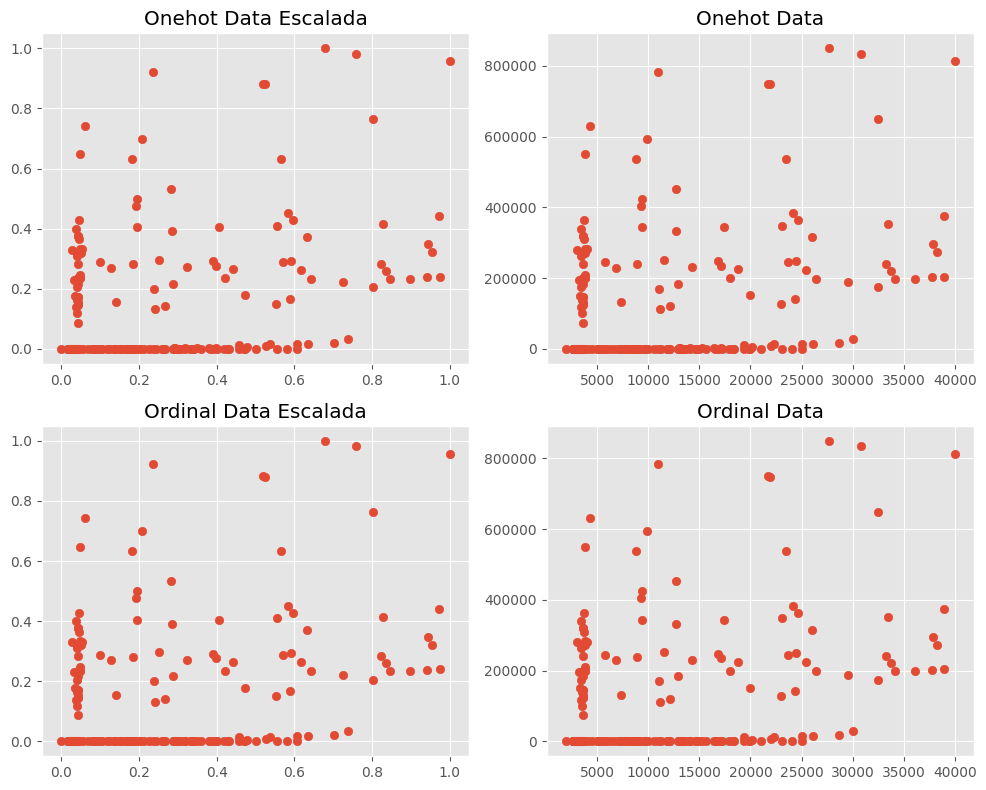

In [22]:
# Importamos
# === Tratamiento de datos =====================================================
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

# === Gráficos =================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# === Preprocesado y modelado ==================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples

# === Configuración warnings ===================================================
import warnings
warnings.filterwarnings('ignore')

# Establecemos una unificación de colores - Obtenido de clase
mapping = {   # Diccionario con formato Target : List of current values
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Cargamos los datos
data = pd.read_csv('data/stars_data.csv')

# Mapeamos los datos
for target_color, source_colors in mapping.items():
  data.loc[data.Color.isin(source_colors), 'Color'] = target_color

# Definimos conjunto de datos principal (del cual se crean el resto de conjunto de datos)
X = data.values

# Iprimimos datos para visualizarlos
print(X)

# Copiamos el conjunto de datos original para preservarlo
X_onehot = X.copy()
X_ordinal = X.copy()

# === Codificamos valores de tipo str (color y clase espectral) ============================
# One-Hot Encoder:
# Definimos el encoder
encoder_onehot = OneHotEncoder(sparse_output=False)

# Definimos las columnas categóricas
onehot_categorical_columns = [-2, -1] 

# Creamos el transformador de columnas
onehot_column_transformer = ColumnTransformer([
    ('onehot', encoder_onehot, onehot_categorical_columns)
])

# Transformamos los datos
X_onehot_encoded = onehot_column_transformer.fit_transform(X_onehot)

# Concatenamos los datos
X_onehot = np.concatenate((X_onehot[:, :-2], X_onehot_encoded), axis=1)

# Ordinal Encoder:
# Definimos listas
spectral_list = ["M", "K", "G", "F", "A", "B", "O"]     # Las definimos de más frías a más calientes, igual que los colores mapeados
colors = list(mapping.keys())

# Definimos el ordinal encoder con las listas
ordinal_encoder = OrdinalEncoder(categories=[colors, spectral_list])

# Definimos las columnas categóricas
ordinal_categorical_columns = [-2, -1]

# Creamos el transformador de columnas
ordinal_column_transformer = ColumnTransformer([
    ('ordinal', ordinal_encoder, ordinal_categorical_columns)
])

# Transformamos los datos
X_ordinal_encoded = ordinal_column_transformer.fit_transform(X_ordinal)

# Concatenamos los datos
X_ordinal = np.concatenate((X_ordinal[:, :-2], X_ordinal_encoded), axis=1)

# Escalamos los datos
scaler = MinMaxScaler()

X_onehot_scaled = scaler.fit_transform(X_onehot)
X_ordinal_scaled = scaler.fit_transform(X_ordinal)

# === Representamos data ==========================================================
# Creamos subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Onehot Data Escalada
axes[0, 0].grid(True)
axes[0, 0].scatter(X_onehot_scaled[:, 0], X_onehot_scaled[:, 1])
axes[0, 0].set_title('Onehot Data Escalada')

# Onehot Data
axes[0, 1].grid(True)
axes[0, 1].scatter(X_onehot[:, 0], X_onehot[:, 1])
axes[0, 1].set_title('Onehot Data')

# Ordinal Data Escalada
axes[1, 0].grid(True)
axes[1, 0].scatter(X_ordinal_scaled[:, 0], X_ordinal_scaled[:, 1])
axes[1, 0].set_title('Ordinal Data Escalada')

# Ordinal Data
axes[1, 1].grid(True)
axes[1, 1].scatter(X_ordinal[:, 0], X_ordinal[:, 1])
axes[1, 1].set_title('Ordinal Data')

# Ajustamos el layout y mostramos subplots
plt.tight_layout()
plt.show()


# PCA
---
Bidimensionamos los datos depués de haberlos preparado. Realizamos la transformación sobre el conjunto de datos escalados y el conjunto no escalado.

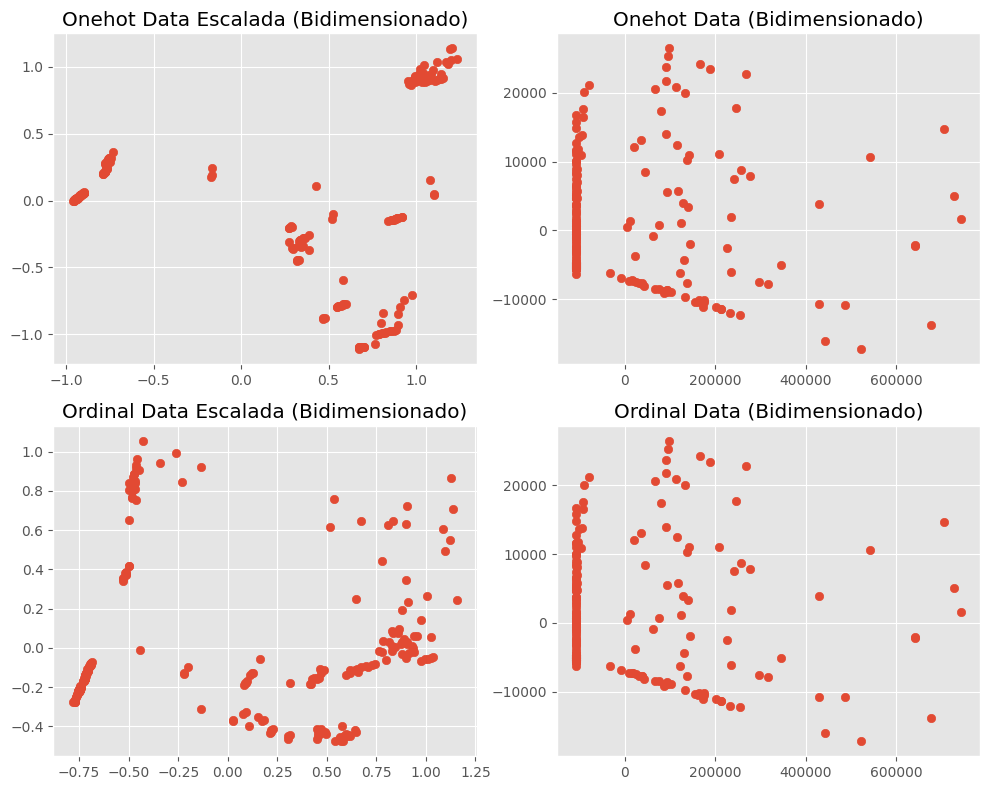

In [23]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca_onehot_scaled = pca.fit_transform(X_onehot_scaled)
X_pca_onehot = pca.fit_transform(X_onehot)
X_pca_ordinal_scaled = pca.fit_transform(X_ordinal_scaled)
X_pca_ordinal = pca.fit_transform(X_ordinal)

# === Representamos data ==========================================================
# Creamos subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Onehot Data Escalada (Bidimensionado)
axes[0, 0].grid(True)
axes[0, 0].scatter(X_pca_onehot_scaled[:, 0], X_pca_onehot_scaled[:, 1])
axes[0, 0].set_title('Onehot Data Escalada (Bidimensionado)')

# Onehot Data (Bidimensionado)
axes[0, 1].grid(True)
axes[0, 1].scatter(X_pca_onehot[:, 0], X_pca_onehot[:, 1])
axes[0, 1].set_title('Onehot Data (Bidimensionado)')

# Ordinal Data Escalada (Bidimensionado)
axes[1, 0].grid(True)
axes[1, 0].scatter(X_pca_ordinal_scaled[:, 0], X_pca_ordinal_scaled[:, 1])
axes[1, 0].set_title('Ordinal Data Escalada (Bidimensionado)')

# Ordinal Data (Bidimensionado)
axes[1, 1].grid(True)
axes[1, 1].scatter(X_pca_ordinal[:, 0], X_pca_ordinal[:, 1])
axes[1, 1].set_title('Ordinal Data (Bidimensionado)')

# Ajustamos el layout y mostramos subplots
plt.tight_layout()
plt.show()


# Clusters
---
Utilizamos el método elbow y el método silhouette para buscar el mejor número de clusters y comenzar la comparación de nuestro algoritmo KMeans con el KMeans de Sci-Kit.

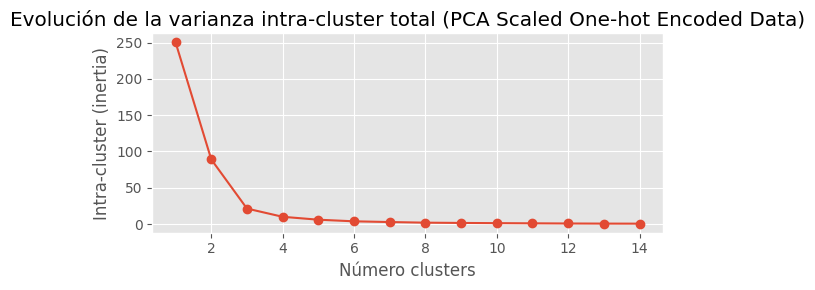

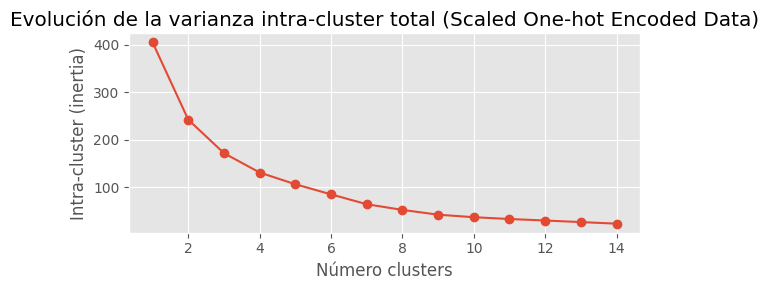

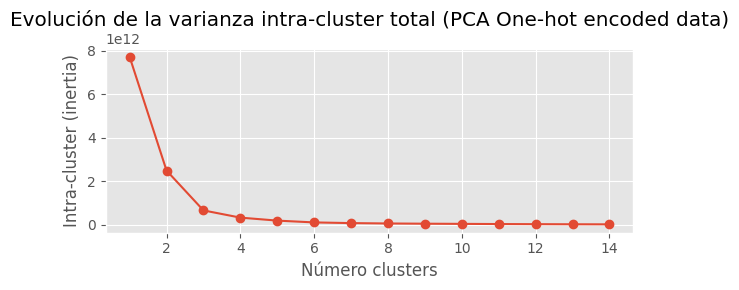

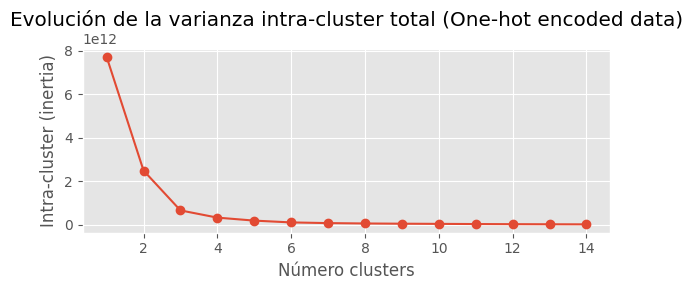

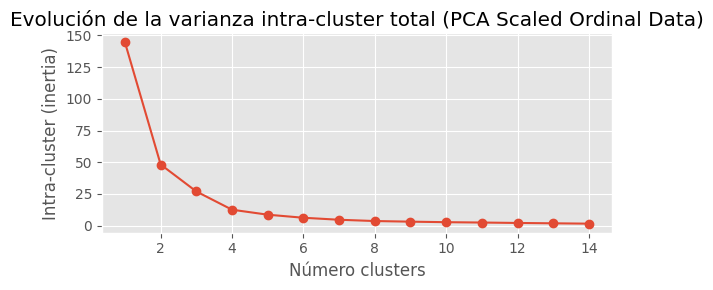

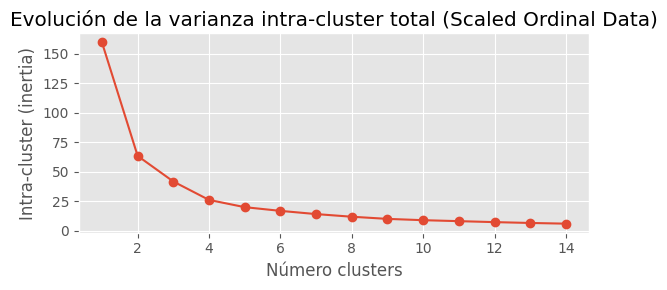

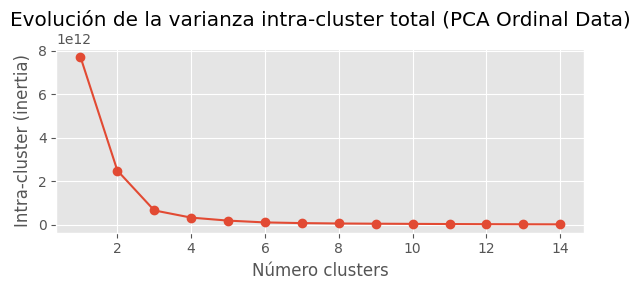

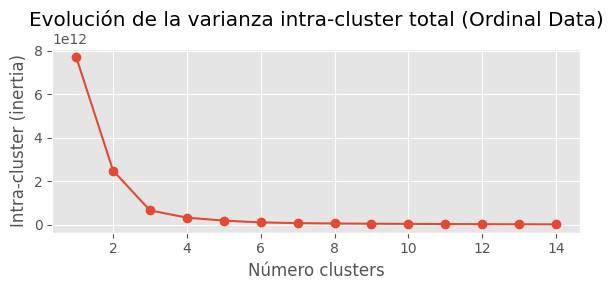

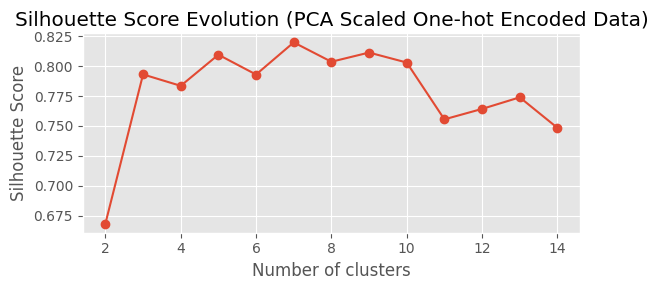

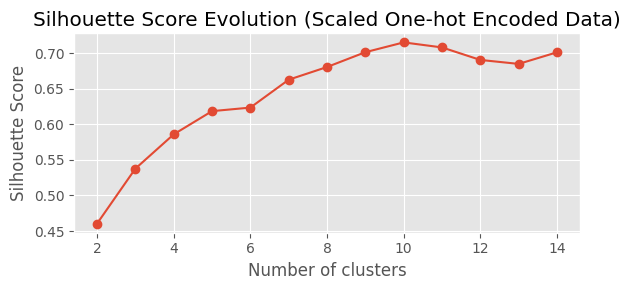

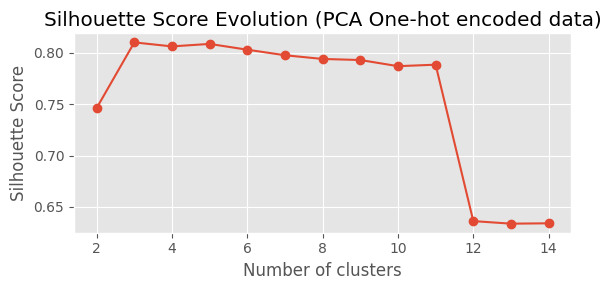

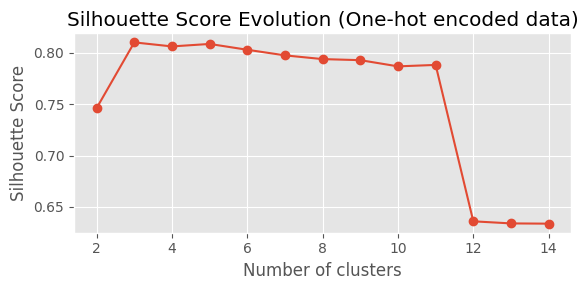

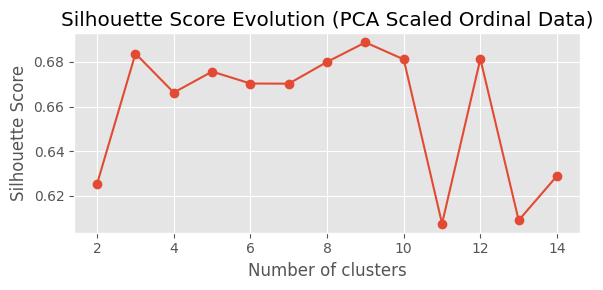

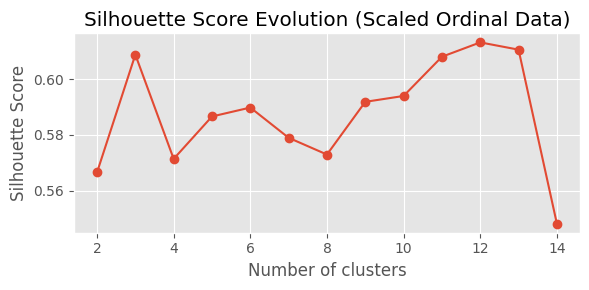

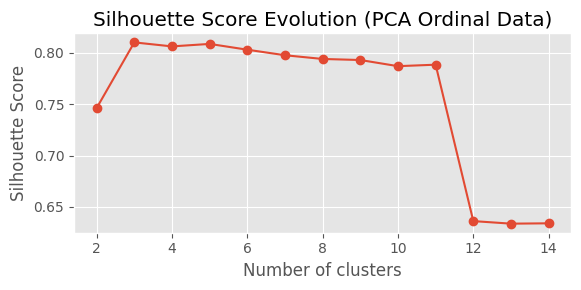

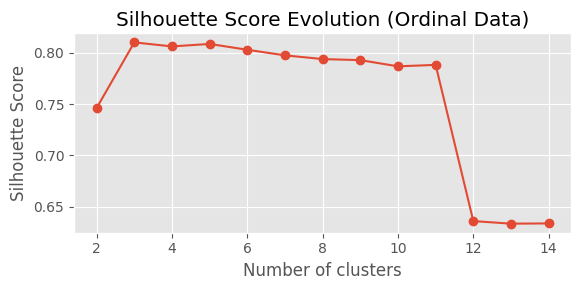

In [24]:
def n_clusters_elbow_method(X, data_type: str):
    range_n_clusters = range(1, 15)
    inertias = []

    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(
            n_clusters   = n_clusters,
            n_init       = 20,
            random_state = 100572303
        )
        modelo_kmeans.fit(X)
        inertias.append(modelo_kmeans.inertia_)

    # Creamos plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    
    ax.plot(range_n_clusters, inertias, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster total ({})".format(data_type))
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)')

    # Ajustamos el layout y enseñamos el plot
    plt.tight_layout()
    plt.show()

def n_clusters_silhouette_method(X, data_type: str):
    range_n_clusters = range(2, 15) 
    silhouette_scores = []

    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=20,
            random_state=100572303
        )
        modelo_kmeans.fit(X)
        labels = modelo_kmeans.labels_
        silhouette_scores.append(silhouette_score(X, labels))

    # Creamos plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    
    ax.plot(range_n_clusters, silhouette_scores, marker='o')
    ax.set_title("Silhouette Score Evolution ({})".format(data_type))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Score')

    # Ajustamos el layout y enseñamos el plot
    plt.tight_layout()
    plt.show()

# Aplicamos el método elbow a todos los modelos
n_clusters_elbow_method(X_pca_onehot_scaled, "PCA Scaled One-hot Encoded Data")
n_clusters_elbow_method(X_onehot_scaled, "Scaled One-hot Encoded Data")
n_clusters_elbow_method(X_pca_onehot, "PCA One-hot encoded data")
n_clusters_elbow_method(X_onehot, "One-hot encoded data")
n_clusters_elbow_method(X_pca_ordinal_scaled, "PCA Scaled Ordinal Data")
n_clusters_elbow_method(X_ordinal_scaled, "Scaled Ordinal Data")
n_clusters_elbow_method(X_pca_ordinal, "PCA Ordinal Data")
n_clusters_elbow_method(X_ordinal, "Ordinal Data")

# Aplicamos el método silhouette a todos los modelos
n_clusters_silhouette_method(X_pca_onehot_scaled, "PCA Scaled One-hot Encoded Data")
n_clusters_silhouette_method(X_onehot_scaled, "Scaled One-hot Encoded Data")
n_clusters_silhouette_method(X_pca_onehot, "PCA One-hot encoded data")
n_clusters_silhouette_method(X_onehot, "One-hot encoded data")
n_clusters_silhouette_method(X_pca_ordinal_scaled, "PCA Scaled Ordinal Data")
n_clusters_silhouette_method(X_ordinal_scaled, "Scaled Ordinal Data")
n_clusters_silhouette_method(X_pca_ordinal, "PCA Ordinal Data")
n_clusters_silhouette_method(X_ordinal, "Ordinal Data")

Podemos observar mediante la utilización del método elbow que el número de clusters óptimo a usar sería con un k = 3 para nuestros modelos, pero con el método silhouette vemos cierta diferencia dependiendo del subconjunto de datos. Para los datos escalados es mejor utilizar un número más elevado de clusters, pero sin escalado de datos es mejor con tres clusters. Por ello, evaluamos cada modelo con su mejor número de clusters para obtener los mejores resultados posibles. 

# Comparación algoritmos Kmeans
---
Procedemos a comparar nuestro Kmean, frente al predeterminado de la librería de scikit-learn. Hemos decidido llevar a cabo la comparativa entre las distancia manhattan, euclidiana y minkowski, para poder definir cual nos conviene usar para nuestro conjunto de datos.

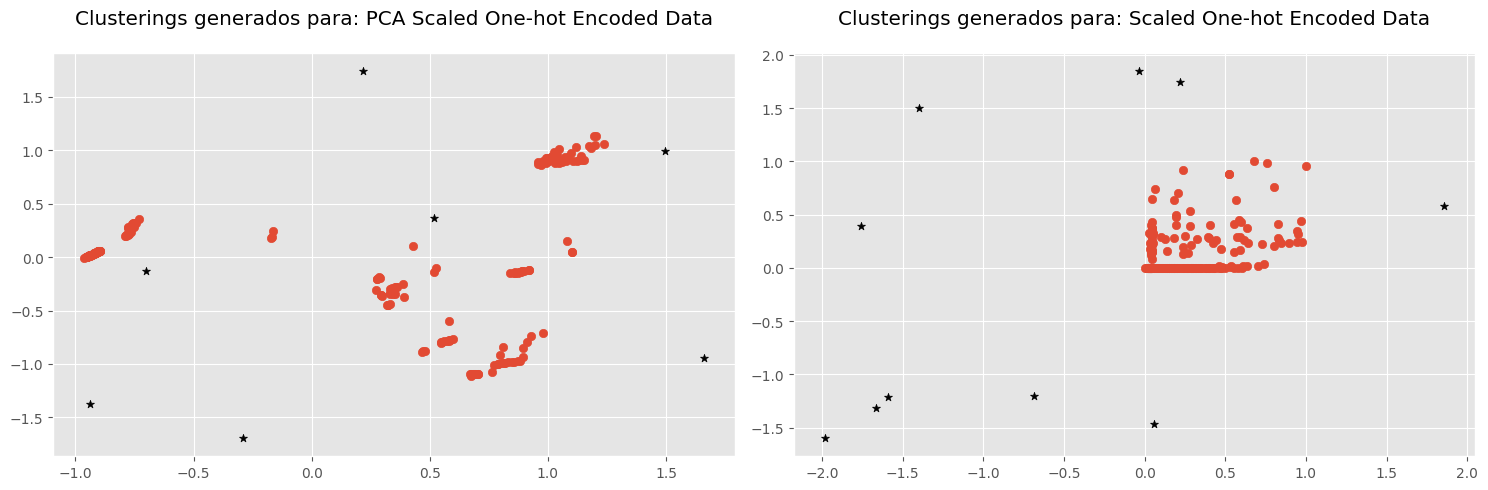

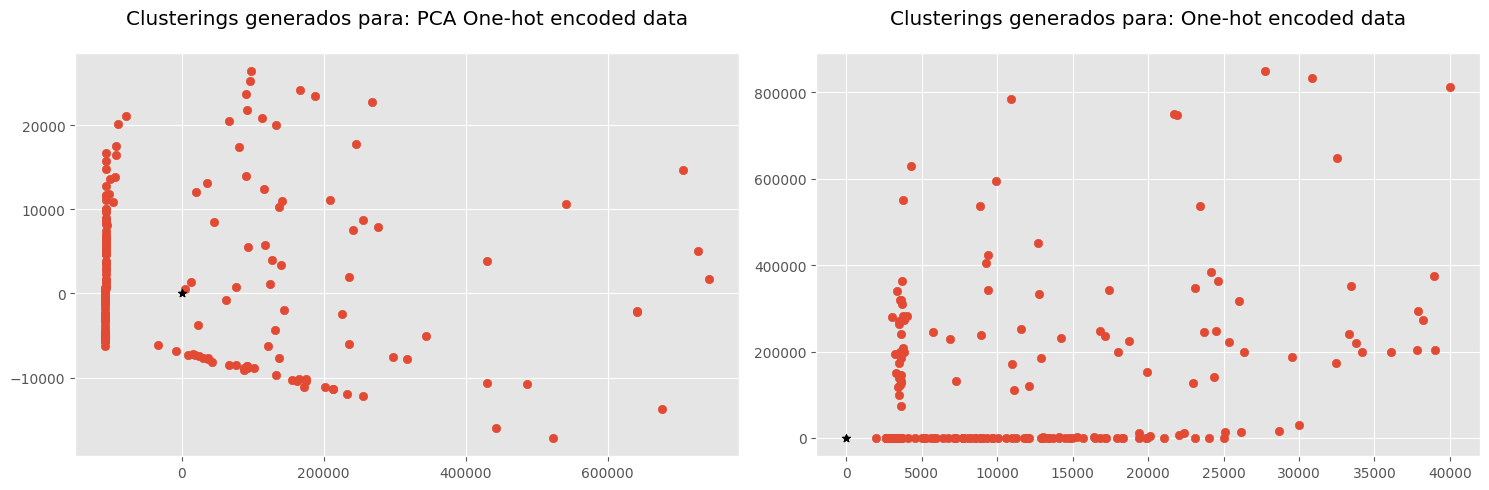

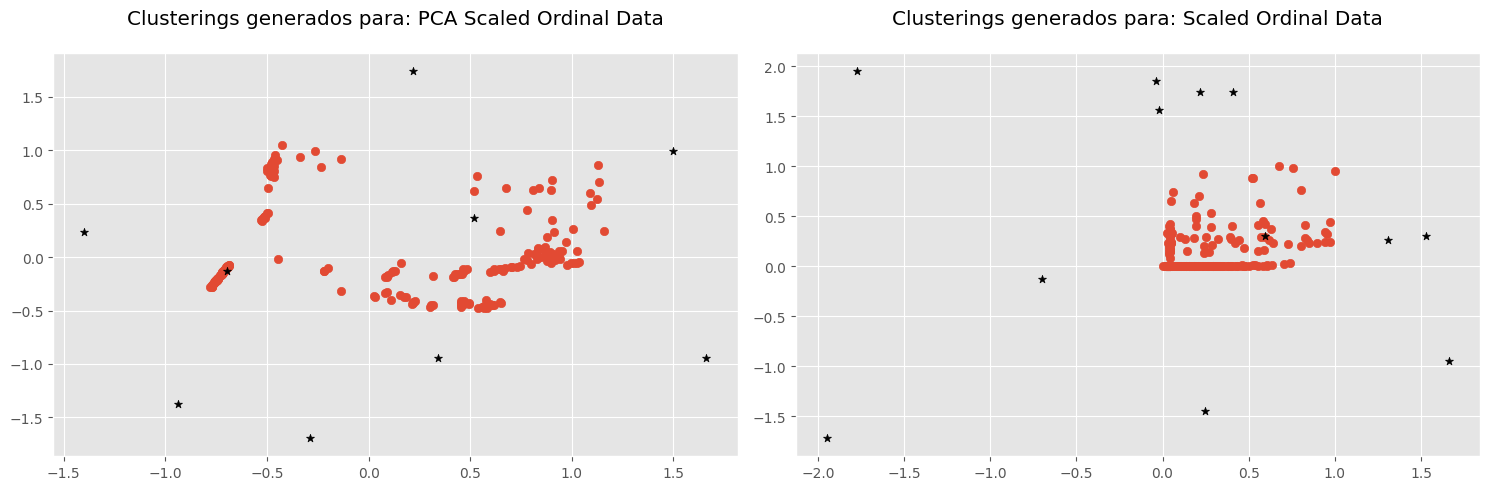

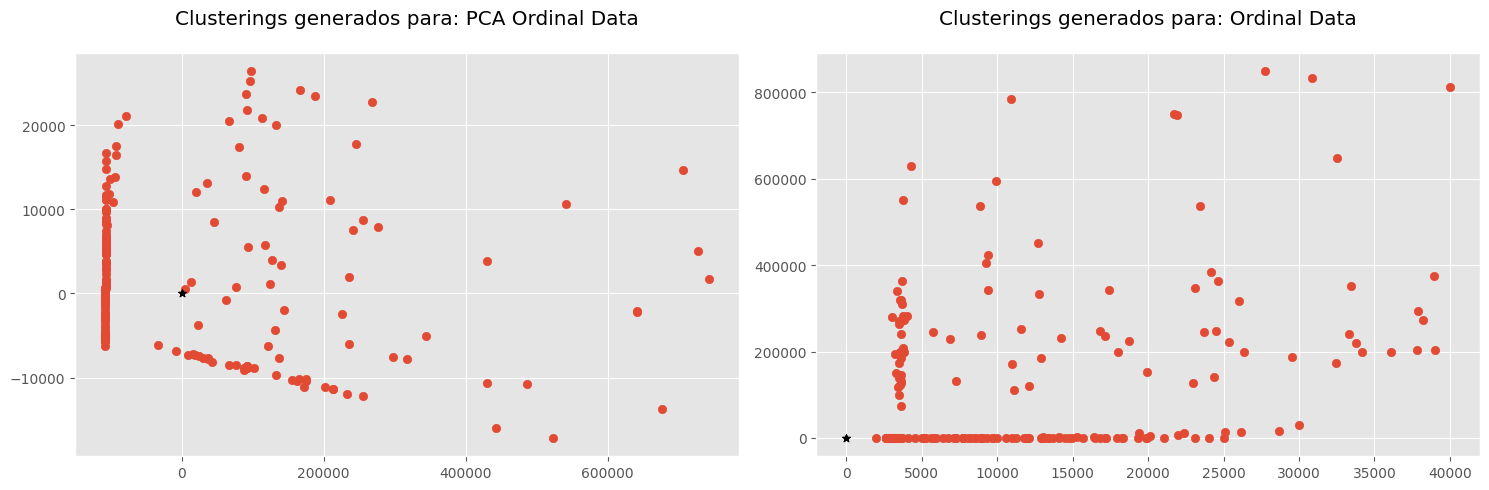

In [25]:
# === Inicialización ==========================================================
# Definimos funciones para inicializar los clusters
def initialize_clusters(clusters_dict, X, k):
    """Función que inicializa clusters"""
    np.random.seed(100472303)

    for idx in range(k):
        center = 2 * (2 * np.random.random((X.shape[1],)) - 1)
        cluster = {
            'center': center,
            'points': []
        }
        clusters_dict[idx] = cluster

def plot_clusters(X, clusters, name):
    """Función que dibuja clusters"""
    plt.scatter(X[:,0], X[:,1])
    plt.grid(True)
    for i in clusters:
        center = clusters[i]['center']
        plt.scatter(center[0], center[1], marker='*', c='black')
    plt.title('Clusterings generados para: ' + name)
    plt.show()

# Inicializamos un diccionario para cada distinto conjunto de datos
clusters_onehot_scaled_pca = {}
clusters_onehot_scaled = {}
clusters_onehot_pca = {}
clusters_onehot = {}
clusters_ordinal_scaled_pca = {}
clusters_ordinal_scaled = {}
clusters_ordinal_pca = {}
clusters_ordinal = {}

# Creamos un dataset para todas las llamadas a las funciones - El número de clusters es el último elemento de un conjunto
datasets = [
    (X_pca_onehot_scaled, clusters_onehot_scaled_pca, "PCA Scaled One-hot Encoded Data", 7),
    (X_onehot_scaled, clusters_onehot_scaled, "Scaled One-hot Encoded Data", 10),
    (X_pca_onehot, clusters_onehot_pca, "PCA One-hot encoded data", 3),
    (X_onehot, clusters_onehot, "One-hot encoded data", 3),
    (X_pca_ordinal_scaled, clusters_ordinal_scaled_pca, "PCA Scaled Ordinal Data", 9),
    (X_ordinal_scaled, clusters_ordinal_scaled, "Scaled Ordinal Data", 12),
    (X_pca_ordinal, clusters_ordinal_pca, "PCA Ordinal Data", 3),
    (X_ordinal, clusters_ordinal, "Ordinal Data", 3)
]

def plot_clusters(X1, X2, clusters1, clusters2, name1, name2):
    """Función que dibuja clusters"""
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].scatter(X1[:,0], X1[:,1])
    for i in clusters1:
        center = clusters1[i]['center']
        axs[0].scatter(center[0], center[1], marker='*', c='black')
    axs[0].set_title('Clusterings generados para: ' + name1, y=1.05)

    axs[1].scatter(X2[:,0], X2[:,1])
    for i in clusters2:
        center = clusters2[i]['center']
        axs[1].scatter(center[0], center[1], marker='*', c='black')
    axs[1].set_title('Clusterings generados para: ' + name2, y=1.05)

    plt.tight_layout()
    plt.show()

# Inicializamos y dibujamos clusters
for i in range(0, len(datasets), 2):
    X1, clusters_dict1, name1, cluster_num1 = datasets[i]
    X2, clusters_dict2, name2, cluster_num2 = datasets[i+1]
    initialize_clusters(clusters_dict1, X1, cluster_num1)
    initialize_clusters(clusters_dict2, X2, cluster_num2)
    plot_clusters(X1, X2, clusters_dict1, clusters_dict2, name1, name2)

=== PCA Scaled One-hot Encoded Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0281 segundos
Coeficiente de Silhouette (custom): 0.7804
Tiempo de ejecución (scikit-learn): 0.0566 segundos
Coeficiente de Silhouette (scikit-learn): 0.8199


=== Scaled One-hot Encoded Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0688 segundos
Coeficiente de Silhouette (custom): 0.3910
Tiempo de ejecución (scikit-learn): 0.0749 segundos
Coeficiente de Silhouette (scikit-learn): 0.7150




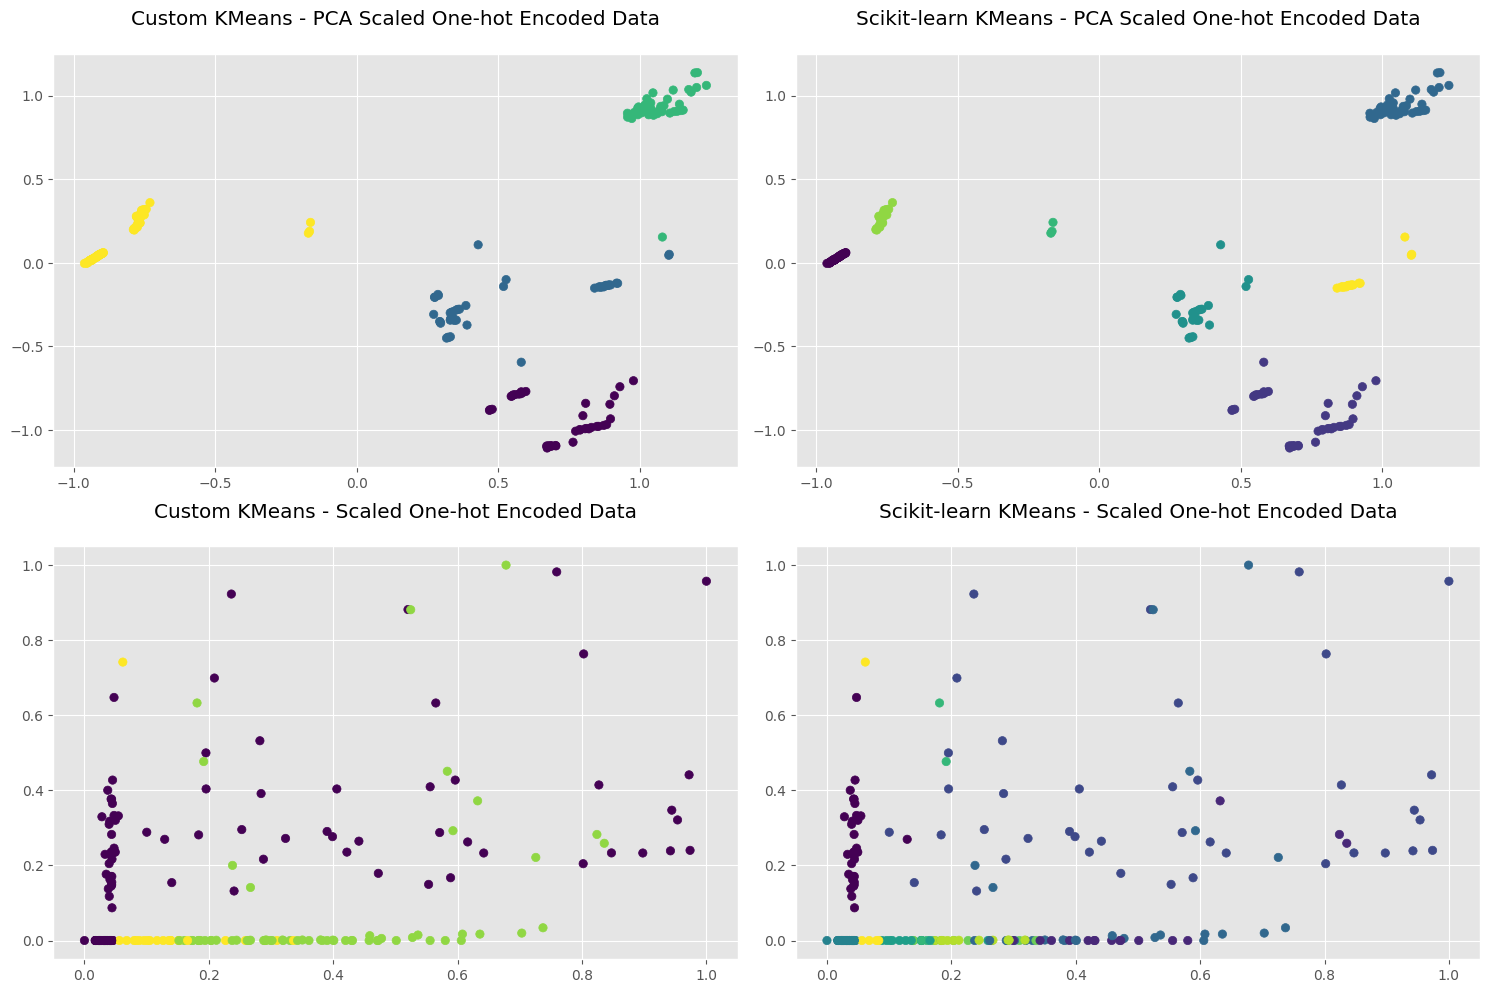

=== PCA One-hot encoded data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0227 segundos
Coeficiente de Silhouette (custom): 0.7908
Tiempo de ejecución (scikit-learn): 0.0468 segundos
Coeficiente de Silhouette (scikit-learn): 0.8103


=== One-hot encoded data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0366 segundos
Coeficiente de Silhouette (custom): 0.8125
Tiempo de ejecución (scikit-learn): 0.0681 segundos
Coeficiente de Silhouette (scikit-learn): 0.8103




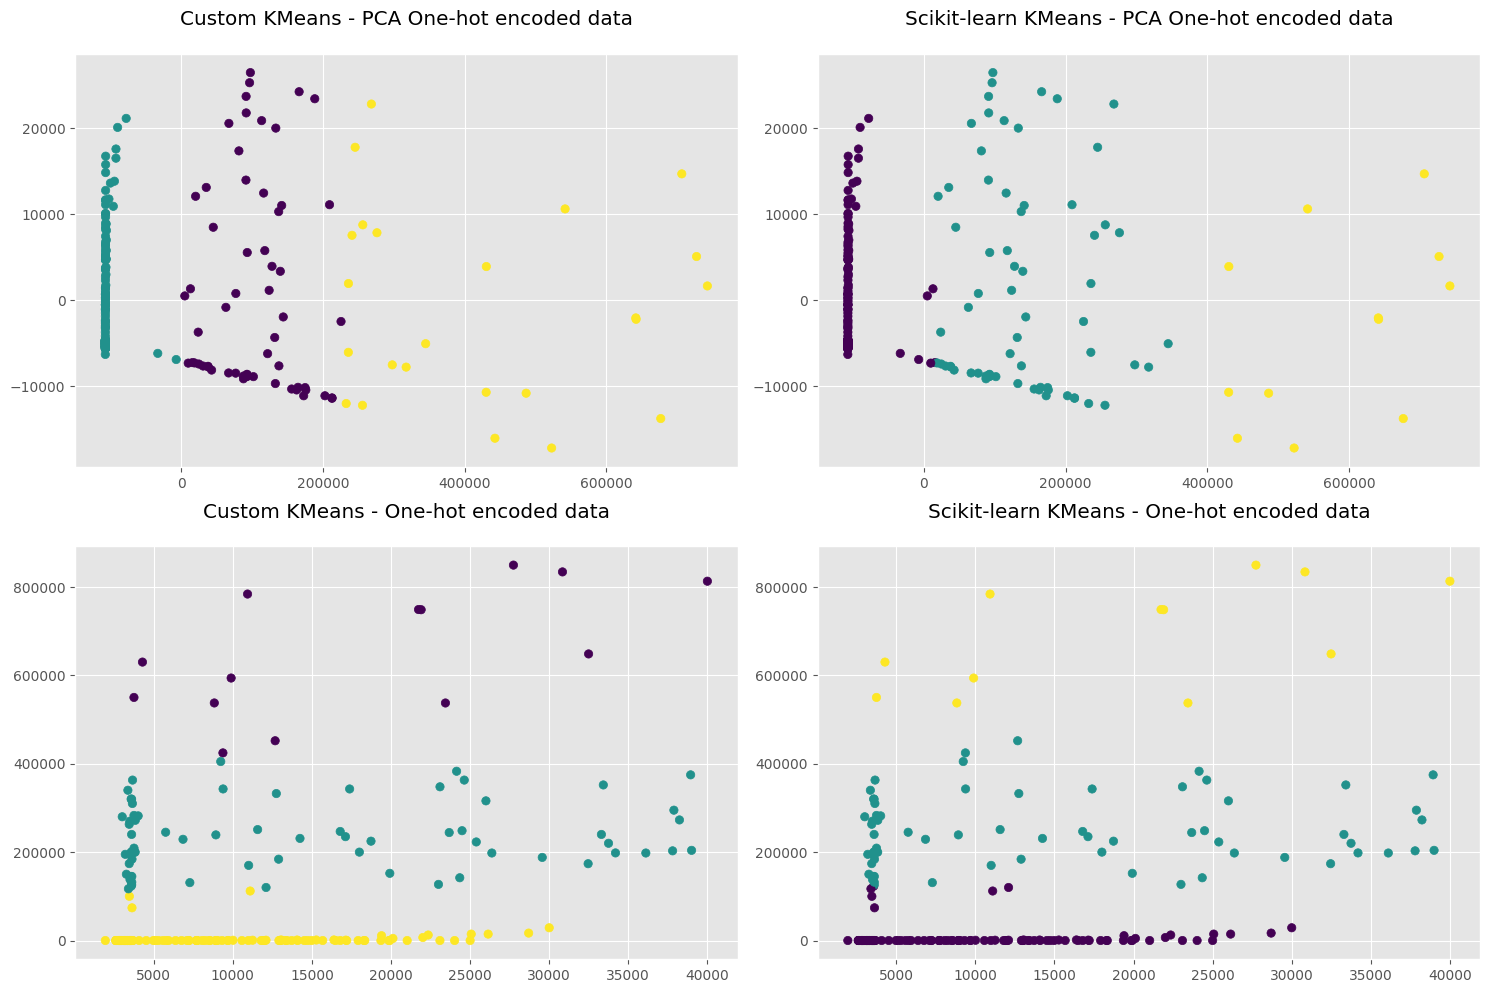

=== PCA Scaled Ordinal Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0461 segundos
Coeficiente de Silhouette (custom): 0.6757
Tiempo de ejecución (scikit-learn): 0.0727 segundos
Coeficiente de Silhouette (scikit-learn): 0.6887


=== Scaled Ordinal Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0649 segundos
Coeficiente de Silhouette (custom): 0.5690
Tiempo de ejecución (scikit-learn): 0.0669 segundos
Coeficiente de Silhouette (scikit-learn): 0.6132




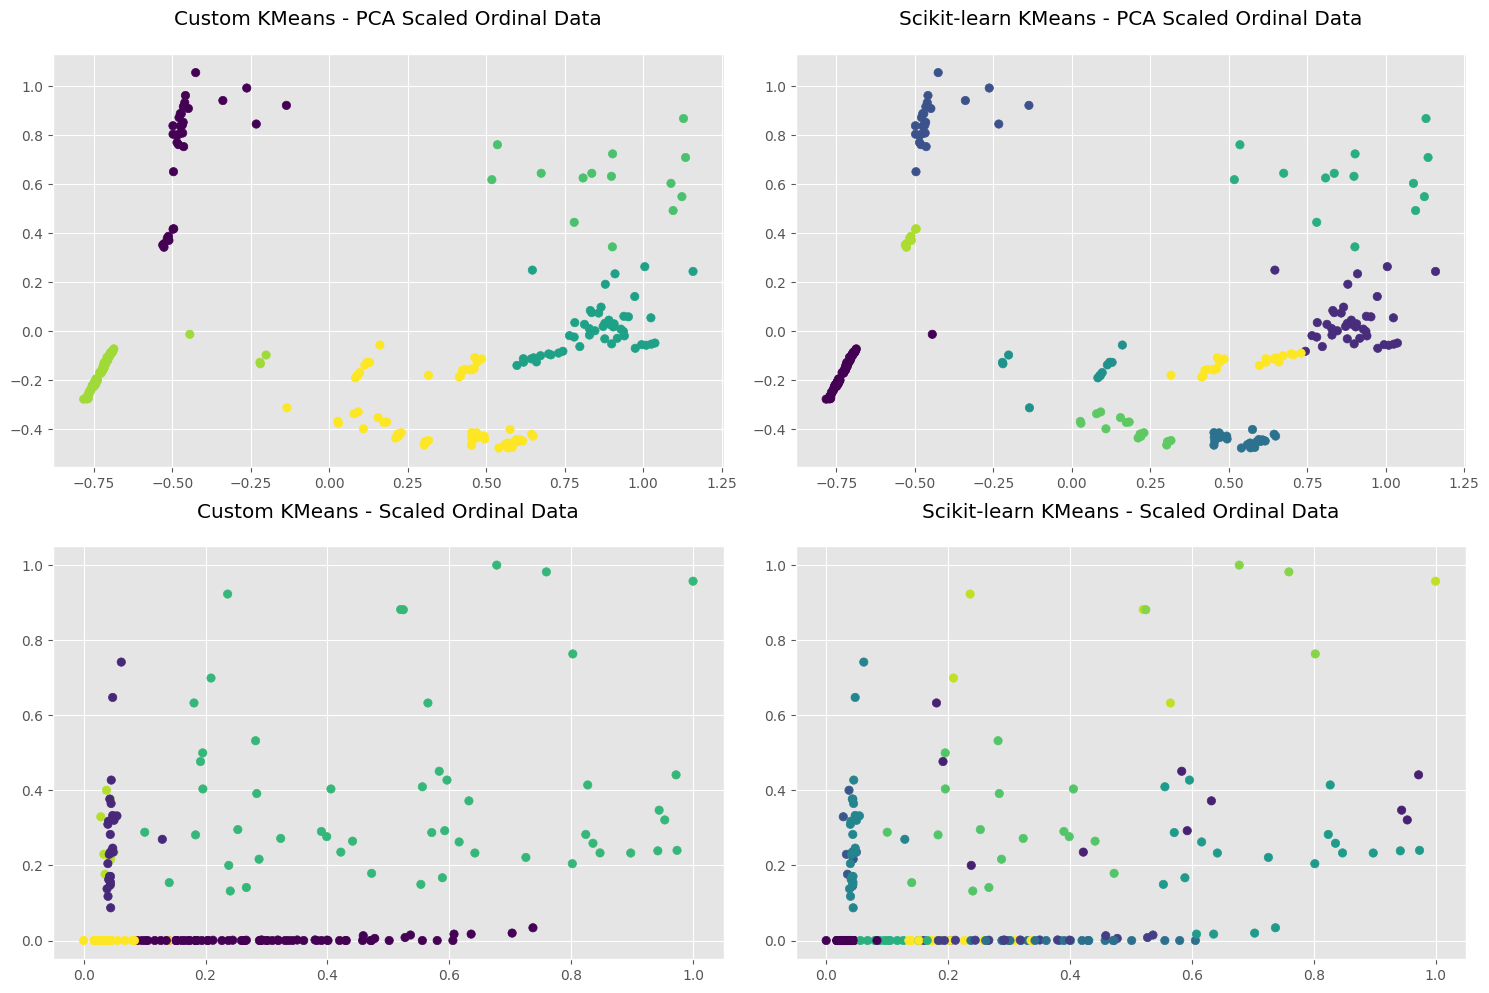

=== PCA Ordinal Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0235 segundos
Coeficiente de Silhouette (custom): 0.7908
Tiempo de ejecución (scikit-learn): 0.0509 segundos
Coeficiente de Silhouette (scikit-learn): 0.8103


=== Ordinal Data ====================================================
Distancia: manhattan
Tiempo de ejecución (custom): 0.0187 segundos
Coeficiente de Silhouette (custom): 0.7826
Tiempo de ejecución (scikit-learn): 0.0476 segundos
Coeficiente de Silhouette (scikit-learn): 0.8103




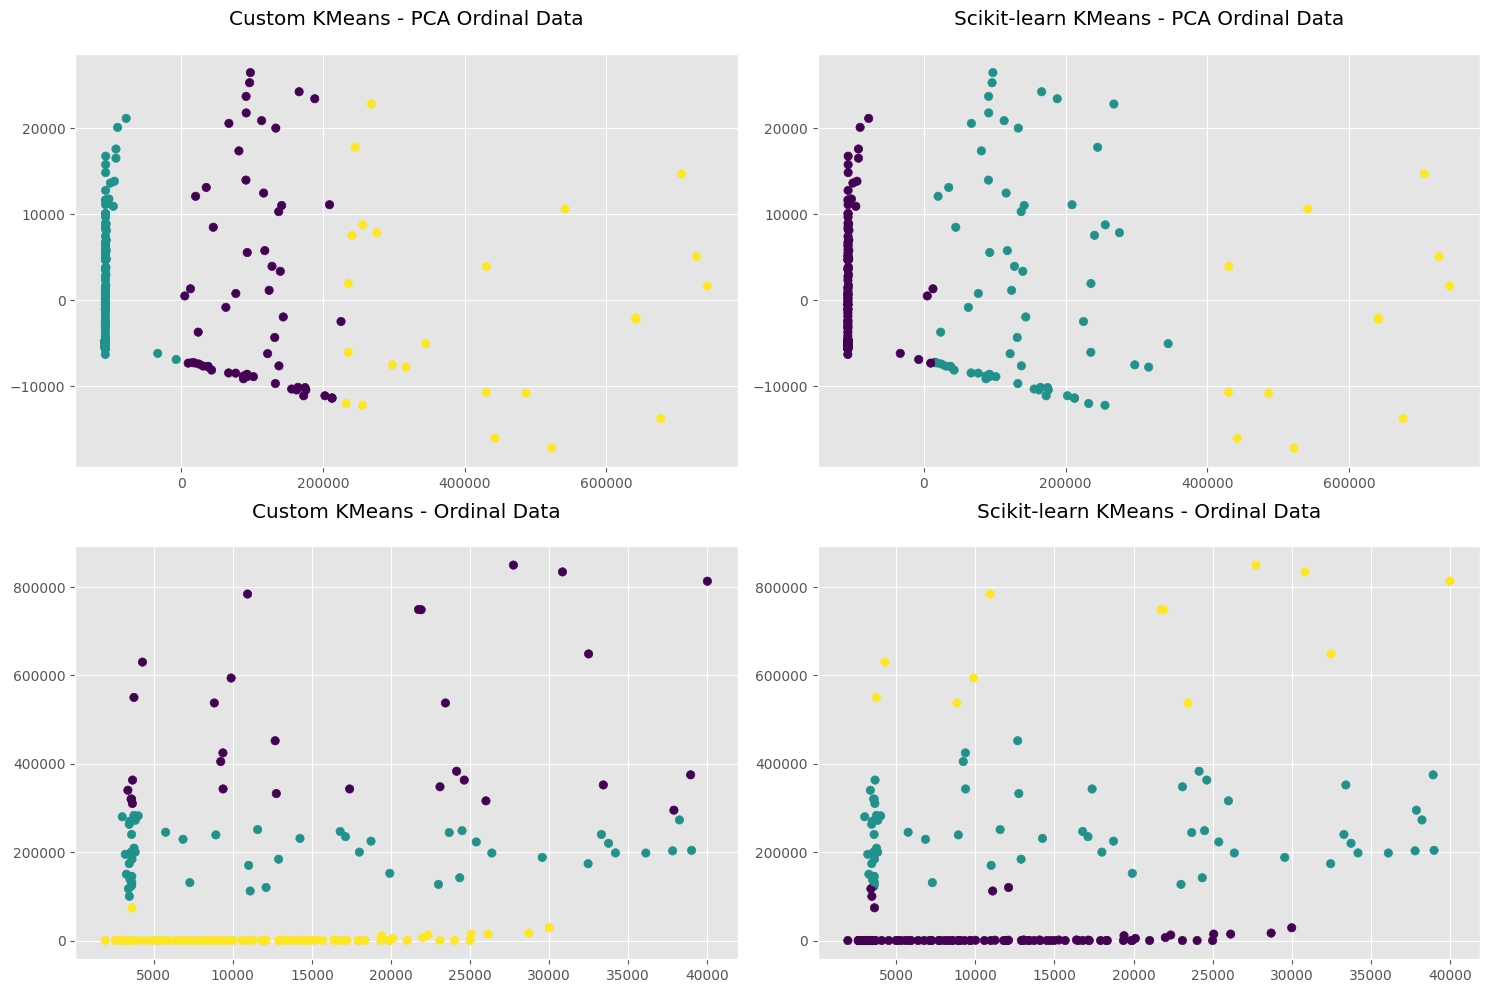

In [26]:
# === Comparación ==========================================================
# Modificamos la función compare_kmeans para que devuelva los resultados
def compare_kmeans(X, clusters, k, model_name, metric='manhattan'):
    # Ejecutamos nuestro KMeans personalizado
    start_time = time.time()
    clusters = myKMeans(X, clusters, k, metric=metric)
    custom_pred = myKMeansPred(X, clusters, k)
    custom_time = time.time() - start_time
    custom_silhouette = silhouette_score(X, custom_pred)

    # Ejecutamos KMeans de scikit-learn
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=100572303)
    sklearn_pred = kmeans.fit_predict(X)
    sklearn_time = time.time() - start_time
    sklearn_silhouette = silhouette_score(X, sklearn_pred)

    # Imprimimos resultados
    # Imprimimos los resultados
    print(f"=== {model_name} ====================================================")
    print(f"Distancia: {metric}")
    print(f"Tiempo de ejecución (custom): {custom_time:.4f} segundos")
    print(f"Coeficiente de Silhouette (custom): {custom_silhouette:.4f}")
    print(f"Tiempo de ejecución (scikit-learn): {sklearn_time:.4f} segundos")
    print(f"Coeficiente de Silhouette (scikit-learn): {sklearn_silhouette:.4f}")
    print("\n")

    # Devolvemos los resultados
    return custom_pred, sklearn_pred

def plot_clusters(X1, X2, custom_pred1, sklearn_pred1, custom_pred2, sklearn_pred2, name1, name2):
    """Función que dibuja clusters"""
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].scatter(X1[:,0], X1[:,1], c=custom_pred1)
    axs[0, 0].set_title(f'Custom KMeans - {name1}', y=1.05)

    axs[0, 1].scatter(X1[:,0], X1[:,1], c=sklearn_pred1)
    axs[0, 1].set_title(f'Scikit-learn KMeans - {name1}', y=1.05)

    axs[1, 0].scatter(X2[:,0], X2[:,1], c=custom_pred2)
    axs[1, 0].set_title(f'Custom KMeans - {name2}', y=1.05)

    axs[1, 1].scatter(X2[:,0], X2[:,1], c=sklearn_pred2)
    axs[1, 1].set_title(f'Scikit-learn KMeans - {name2}', y=1.05)

    plt.tight_layout()
    plt.show()

# Llamamos a la función con los datos y el número de clusters
for i in range(0, len(datasets), 2):
    X1, clusters_dict1, name1, cluster_num1 = datasets[i]
    X2, clusters_dict2, name2, cluster_num2 = datasets[i+1]
    custom_pred1, sklearn_pred1 = compare_kmeans(X1, clusters_dict1, cluster_num1, name1)
    custom_pred2, sklearn_pred2 = compare_kmeans(X2, clusters_dict2, cluster_num2, name2)
    plot_clusters(X1, X2, custom_pred1, sklearn_pred1, custom_pred2, sklearn_pred2, name1, name2)

Observamos una pequeña diferencia entre ambos algoritmos y el tiempo que toma en ejecutar. También observamos una diferencia destacable en el uso de one-hot encoding o ordinal encoding, en escalar los datos y en bidimensionarlos también. Describimos con detalle las diferencias más abajo en el apartado de conclusiones.

# Algorimos alternativos
---
Hemos decidido aplicar el algoritmo DBSCAN debido a que al realizar un análisis de las gráficas anteriormente dibujadas podemos observar que hay una cantidad considerable de outliers. Aplicando dicho algoritmo podemos controlar de mejor forma estos outliers.

### Calculamos Silhouette Score
---
Realizamos este paso para poder comparar los resultados con los resultados del KMeans.

Silhouette Score for PCA Scaled One-hot Encoded Data : 0.7881154502828422
Silhouette Score for Scaled One-hot Encoded Data : 0.5733566442320888
Cannot compute silhouette score for PCA One-hot encoded data - Insufficient clusters present.
Cannot compute silhouette score for One-hot encoded data - Insufficient clusters present.


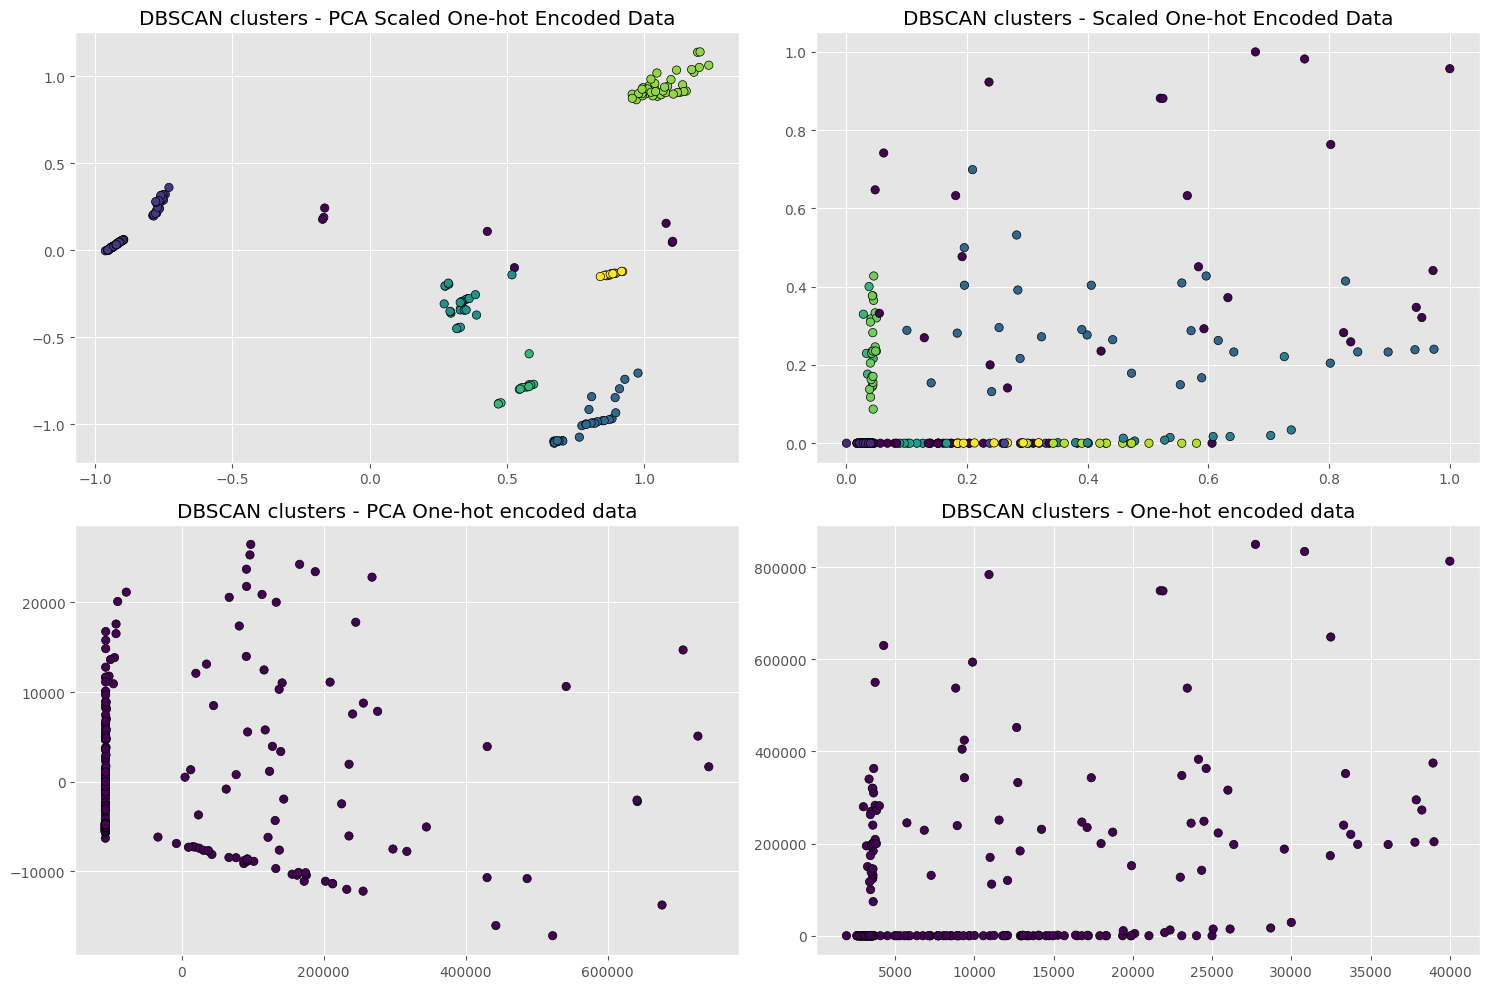

Silhouette Score for PCA Scaled Ordinal Data : 0.5853877183161936
Silhouette Score for Scaled Ordinal Data : 0.5092827187732372
Cannot compute silhouette score for PCA Ordinal Data - Insufficient clusters present.
Cannot compute silhouette score for Ordinal Data - Insufficient clusters present.


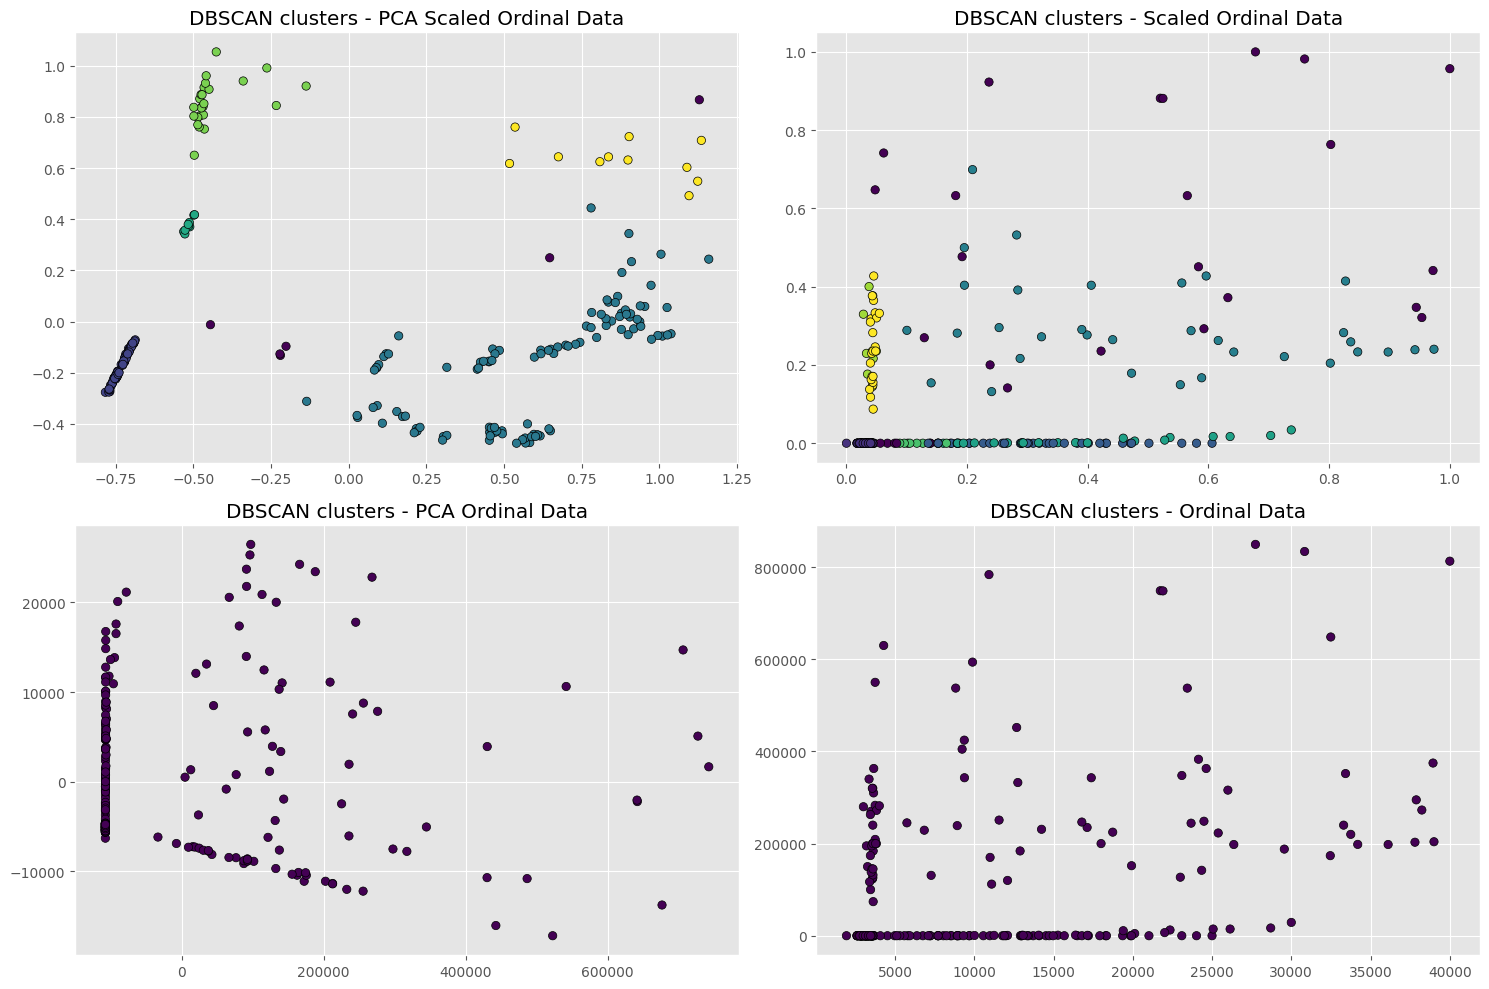

In [27]:
# Importamos
from sklearn.cluster import DBSCAN

def compare_dbscan(X, eps=0.2, min_samples=5, metric='euclidean'):
    """Función que aplica DBSCAN y devuelve las predicciones"""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    dbscan_pred = dbscan.fit_predict(X)
    return dbscan_pred

def plot_clusters(X1, X2, X3, X4, dbscan_pred1, dbscan_pred2, dbscan_pred3, dbscan_pred4, name1, name2, name3, name4):
    """Función que dibuja clusters"""
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot for X1
    axs[0, 0].scatter(X1[:,0], X1[:,1], c=dbscan_pred1, marker='o', edgecolor='black')
    axs[0, 0].set_title('DBSCAN clusters - ' + name1)
    unique_labels1 = np.unique(dbscan_pred1)
    if len(unique_labels1) > 1:
        silhouette_avg1 = silhouette_score(X1, dbscan_pred1)
        print("Silhouette Score for", name1, ":", silhouette_avg1)
    else:
        print("Cannot compute silhouette score for", name1, "- Insufficient clusters present.")

    # Plot for X2
    axs[0, 1].scatter(X2[:,0], X2[:,1], c=dbscan_pred2, marker='o', edgecolor='black')
    axs[0, 1].set_title('DBSCAN clusters - ' + name2)
    unique_labels2 = np.unique(dbscan_pred2)
    if len(unique_labels2) > 1:
        silhouette_avg2 = silhouette_score(X2, dbscan_pred2)
        print("Silhouette Score for", name2, ":", silhouette_avg2)
    else:
        print("Cannot compute silhouette score for", name2, "- Insufficient clusters present.")

    # Plot for X3
    axs[1, 0].scatter(X3[:,0], X3[:,1], c=dbscan_pred3, marker='o', edgecolor='black')
    axs[1, 0].set_title('DBSCAN clusters - ' + name3)
    unique_labels3 = np.unique(dbscan_pred3)
    if len(unique_labels3) > 1:
        silhouette_avg3 = silhouette_score(X3, dbscan_pred3)
        print("Silhouette Score for", name3, ":", silhouette_avg3)
    else:
        print("Cannot compute silhouette score for", name3, "- Insufficient clusters present.")

    # Plot for X4
    axs[1, 1].scatter(X4[:,0], X4[:,1], c=dbscan_pred4, marker='o', edgecolor='black')
    axs[1, 1].set_title('DBSCAN clusters - ' + name4)
    unique_labels4 = np.unique(dbscan_pred4)
    if len(unique_labels4) > 1:
        silhouette_avg4 = silhouette_score(X4, dbscan_pred4)
        print("Silhouette Score for", name4, ":", silhouette_avg4)
    else:
        print("Cannot compute silhouette score for", name4, "- Insufficient clusters present.")

    plt.tight_layout()
    plt.show()

# Llamamos a la función con los datos
for i in range(0, len(datasets), 4):
    X1, clusters_dict1, name1, cluster_num1 = datasets[i]
    X2, clusters_dict2, name2, cluster_num2 = datasets[i+1]
    X3, clusters_dict3, name3, cluster_num3 = datasets[i+2]
    X4, clusters_dict4, name4, cluster_num4 = datasets[i+3]
    dbscan_pred1 = compare_dbscan(X1)
    dbscan_pred2 = compare_dbscan(X2)
    dbscan_pred3 = compare_dbscan(X3)
    dbscan_pred4 = compare_dbscan(X4)
    plot_clusters(X1, X2, X3, X4, dbscan_pred1, dbscan_pred2, dbscan_pred3, dbscan_pred4, name1, name2, name3, name4)

### Calculamos Clusters y Outliers
---

Gráfica One-hot encoded data:
Número de clusters encontrados: 0
Número de outliers encontrados: 240
--------------------------------------------------
Gráfica Scaled One-hot encoded data:
Número de clusters encontrados: 9
Número de outliers encontrados: 48
--------------------------------------------------
Gráfica PCA one-hot encoded data:
Número de clusters encontrados: 0
Número de outliers encontrados: 240
--------------------------------------------------
Gráfica PCA scaled One-hot encoded data:
Número de clusters encontrados: 6
Número de outliers encontrados: 8
--------------------------------------------------


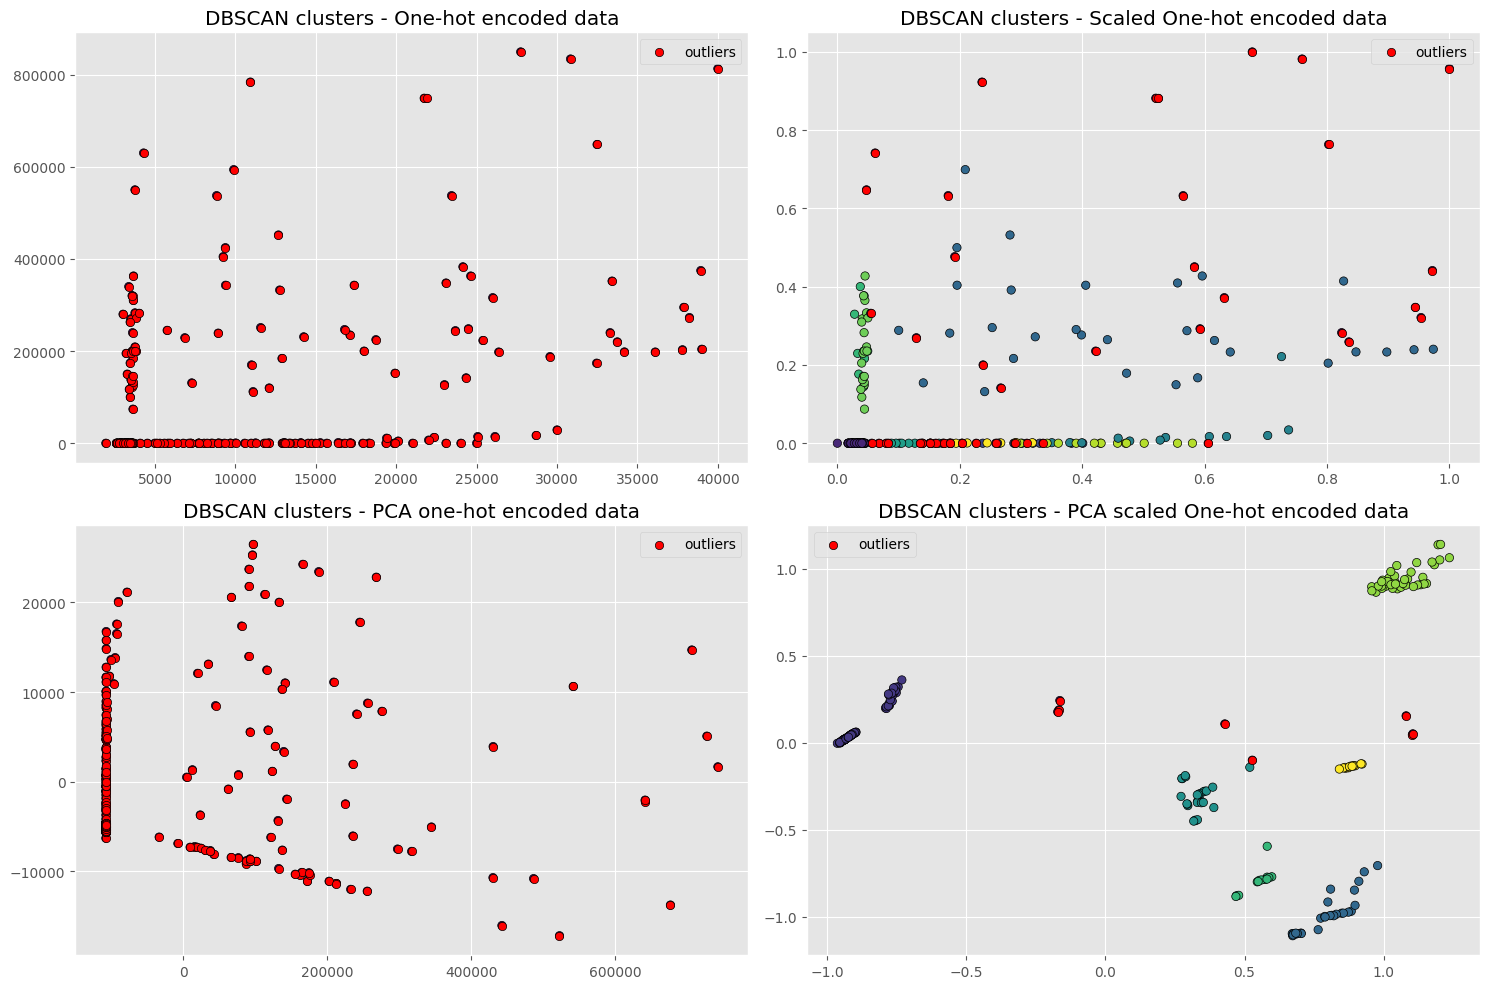

Gráfica Ordinal data:
Número de clusters encontrados: 0
Número de outliers encontrados: 240
--------------------------------------------------
Gráfica Scaled Ordinal data:
Número de clusters encontrados: 7
Número de outliers encontrados: 27
--------------------------------------------------
Gráfica PCA Ordinal data:
Número de clusters encontrados: 0
Número de outliers encontrados: 240
--------------------------------------------------
Gráfica PCA Scaled Ordinal data:
Número de clusters encontrados: 5
Número de outliers encontrados: 6
--------------------------------------------------


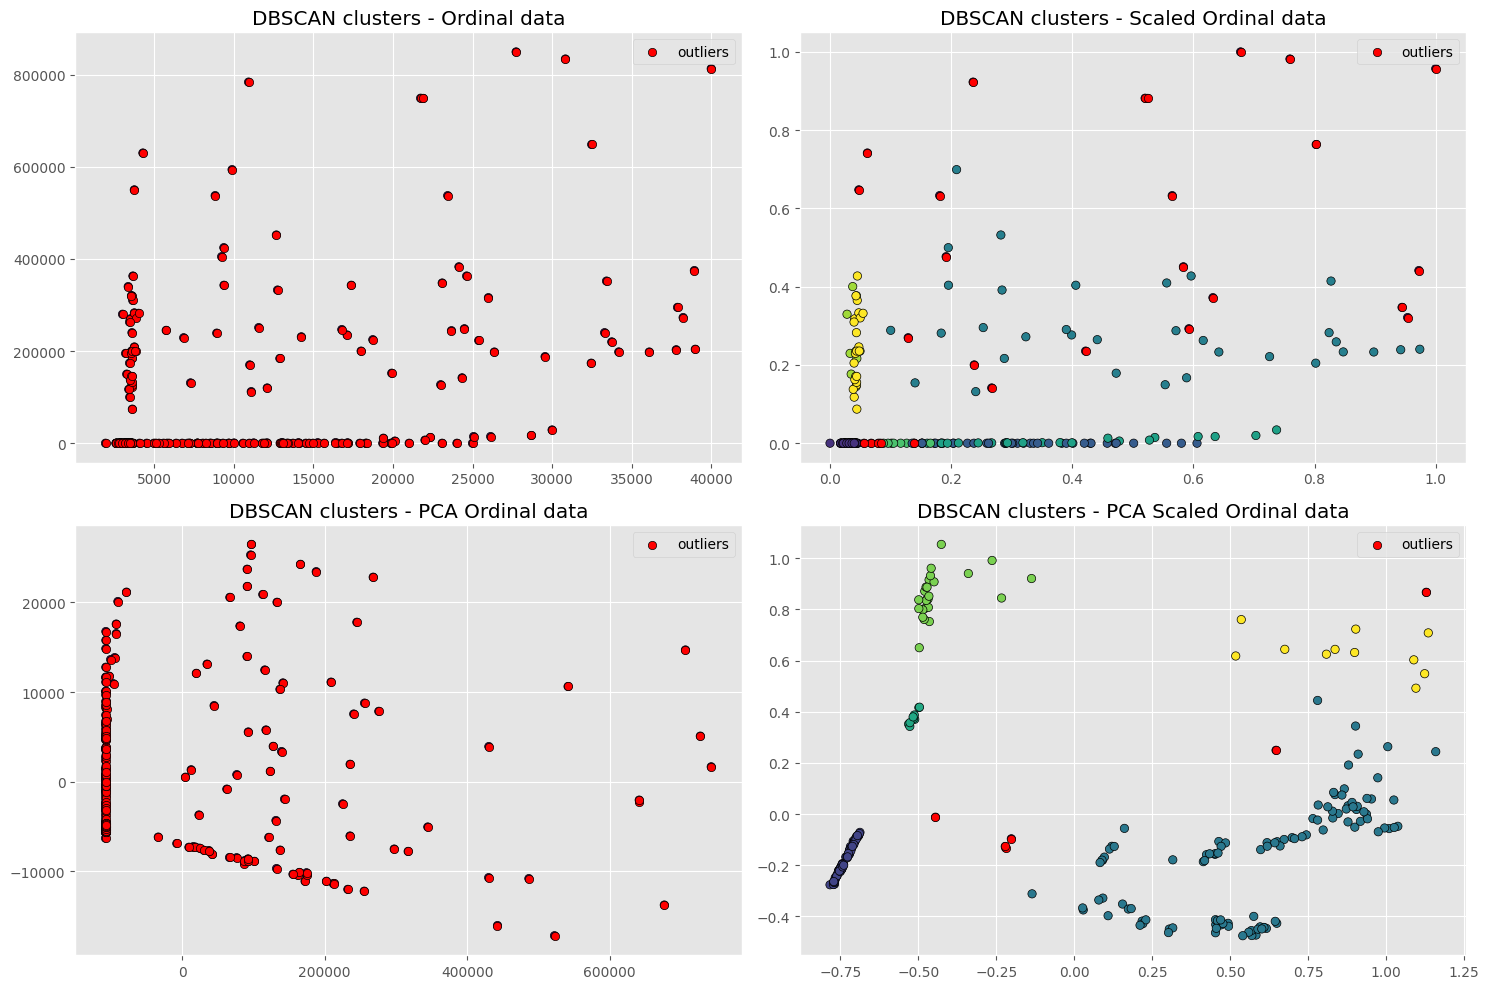

In [28]:
# Modelos
# ==============================================================================
modelo_dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')

# Datos
# ==============================================================================
datasets_onehot = [X_onehot, X_onehot_scaled, X_pca_onehot, X_pca_onehot_scaled]
datasets_names_onehot = ['One-hot encoded data', 'Scaled One-hot encoded data', 'PCA one-hot encoded data', 'PCA scaled One-hot encoded data']

datasets_ordinal = [X_ordinal, X_ordinal_scaled, X_pca_ordinal, X_pca_ordinal_scaled]
datasets_names_ordinal = ['Ordinal data', 'Scaled Ordinal data', 'PCA Ordinal data', 'PCA Scaled Ordinal data']

def fit_and_plot(datasets, datasets_names, title):
    """Función que ajusta el modelo y crea las gráficas"""
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for i in range(len(datasets)):
        modelo_dbscan.fit(datasets[i])
        labels = modelo_dbscan.labels_
        axs[i//2, i%2].scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels, marker='o', edgecolor='black')
        axs[i//2, i%2].scatter(datasets[i][labels == -1, 0], datasets[i][labels == -1, 1], c='red', marker='o', edgecolor='black', label='outliers')
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_title('DBSCAN clusters - ' + datasets_names[i])
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise    = list(labels).count(-1)
        print(f'Gráfica {datasets_names[i]}:')
        print(f'Número de clusters encontrados: {n_clusters}')
        print(f'Número de outliers encontrados: {n_noise}')
        print('--------------------------------------------------')

    plt.tight_layout()
    plt.show()

# Llamada a la función
# ==============================================================================
fit_and_plot(datasets_onehot, datasets_names_onehot, 'One hot encoded')
fit_and_plot(datasets_ordinal, datasets_names_ordinal, 'Ordinal')

# Discusión de resultados
---
A continuación realizamos una breve conclusión de los resultados obtenidos para ambos métodos.
- KMeans: Observamos que en la mayoría de los casos el KMeans de scikit-learn obtiene mejores resultados que nuestro custom KMeans. Sin embargo, se observa que los resultados son muy similares (con excepción del subconjunto de datos Scaled One-hot) y que incluso en un caso nuestro algoritmo obtiene mejores valores para el Silhouette Score, siendo este para el subconjunto de datos One-hot. En cuanto a tiempo de ejecución, observamos que nuestro algoritmo obtiene mejores tiempos de ejecución que el algoritmo de scikit-learn. Destacamos que no es una diferencia muy grande, pero ciertamente es significativa. El escenario que mejores resultados produce es con el KMeans de scikit-learn usando el subconjunto PCA Scaled One-hot data.
- DBSCAN: A partir de los resultados, podemos observar tres cosas de interés. Para empezar, los conjuntos de datos que menos outliers encuentran son aquellos que han sufrido un escalado y una bidimensionalidad de los datos. Luego, observamos que el conjunto de datos escalado y no bidimensionado ha encontrado el mayor número de clusters. Finalmente, observamos que, extrañamente, si el conjunto de datos no se encuentra escalado, no se encuentran clusters. Es un caso interesante de estudio. Para concluir, el conjunto de datos PCA Scaled Ordinal data encuentra menos outliers mientras que el conjunto de datos PCA Scaled One-hot data obtiene un mejor Silhouette Score.

A continuación hacemos comparaciones sobre el uso de one-hot encoding o ordinal encoding, sobre el escalado de datos y sobre bidimensionarlos.
Observamos que en la mayoría de los casos el one-hot encoding ofrece mejores resultados que el ordinal encoding. En el KMeans no es una diferencia muy grande, pero en el DBSCAN si resulta más significativa la diferencia. Concluimos, por tanto, que es mejor utilizar el one-hot encoding. En cuanto al escalado de datos, para KMeans observamos que en algunos casos escalar los datos es mejor y en otros peor. Utilizando one-hot encoding, es mejor escalar los datos cuando se bidimensionan, pero en caso contrario resulta mejor no escalarlos. Sin embargo, usando el ordinal encoding es mejor no escalarlos. Por ello, si vamos a utilizar one-hot encoding es mejor escalar los datos si los vamos a bidimensionar. Pero si usamos el ordinal encoding es mejor no escalarlos. Para DBSCAN es mejor siempre escalarlos, ya que al no escalarlos no encontramos clusters suficientes. En cuanto al PCA, observamos que bidimensionar los datos o mejora los resultados o los mantiene, por lo que conectamos su uso a la decisión del escalado y el método de encoding que se aplica, ya que dependiendo de esto se pueden obtener mejores resultados o no. Es decir, ciertas transformaciones se aprovechan más de realizar el PCA y por tanto ofrecen mejores resultados con este. Consideramos que es mejor bidimensionar los datos y evitar aplicar las transformaciones que no se aprovechan de este paso, ya que nunca empeora los resultados.

Comparando ambos algoritmos, podemos ver que el mejor Silhouette Score nos lo proporciona el KMeans con el PCA Scaled One-hot data. Cabe destacar que para el análisis de resultados se ha comparado el rendimiento con el Standard Scaler y con el MinMax Scaler. El MinMax Scaler fue el método de escalado que mejores resultados reprodució, aunque haya sido por una diferencia muy pequeña.

En cuanto al punto 6 del enunciado, observamos que hay cierta similitud con el número de grupos obtenidos en el DBSCAN. En concreto, con el PCA Scaled One-Hot data obtenemos exáctamente 6 grupos distintos. Usando el ordinal encoder obtenemos unos resultados más similares, ya que devuelven 5 y 7 clusters, mientras que con el one-hot encoder los modelos devuelven de 6 y 9 grupos. Esto es en cuanto a número de clases. Se observa un rango similar de clusters con el KMeans. Por ejemplo, el mejor modelo, que es el modelo con el conjunto de datos PCA Scaled One-hot, obtenemos los mejores resultados con 7 clusters. Hacemos un análisis visual de los valores promedios de cada cluster de nuestro mejor modelo en comparación con la tabla tras realizar nuestro pipeline.

# Pipeline a realizar
---
Hacemos la creación de una pipeline que genera nuestro modelo utilizando la mejor configuración encontrada en el desarrollo del estudio. La pipeline a realizar será con el algoritmo KMeans y el subconjunto bidimensionado y escalado.

In [29]:
# Importamos
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Establecemos una unificación de colores - Obtenido de clase
mapping = {   # Diccionario con formato Target : List of current values
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Cargamos los datos
data = pd.read_csv('data/stars_data.csv')

# Mapeamos los datos
for target_color, source_colors in mapping.items():
  data.loc[data.Color.isin(source_colors), 'Color'] = target_color

X = data.values

# Definimos One-Hot Encoder
encoder_onehot = OneHotEncoder(sparse_output=False)

# Definimos columnas categóricas para el One-Hot Encoder
onehot_categorical_columns = [-2, -1]

# Definimos el transformador de columnas
onehot_column_transformer = ColumnTransformer([
    ('onehot', encoder_onehot, onehot_categorical_columns)
])

# Definimos los pasos del pipeline
steps = [
    ('onehot', onehot_column_transformer),  
    ('scaler', MinMaxScaler()),  
    ('pca', PCA(n_components=2)),  
    ('kmeans', KMeans(n_clusters=7, n_init=20, random_state=100472303))
]

# Creamos pipeline
pipeline = Pipeline(steps)

# Fit 
pipeline.fit(X)

Pipeline(steps=[('onehot',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  [-2, -1])])),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=7, n_init=20, random_state=100472303))])

# Comparación con tabla
---
Hacemos la creación de una pipeline que genera nuestro modelo utilizando la mejor configuración encontrada en el desarrollo del estudio. La pipeline a realizar será con el algoritmo KMeans y el subconjunto bidimensionado y escalado.

In [30]:
# Definimos KMeans - El algoritmo con mejores resultados
kmeans = KMeans(n_clusters=7, n_init=20, random_state=100472303)

# Copiamos el conjunto de datos original para preservarlo
X_onehot = X.copy()

# Transformamos los datos
X_onehot_encoded = onehot_column_transformer.fit_transform(X_onehot)

# Concatenamos los datos
X_onehot = np.concatenate((X_onehot[:, :-2], X_onehot_encoded), axis=1)

X_onehot_df = pd.DataFrame(X_onehot)

for column in X_onehot_df.columns:
    # Check if any non-numeric values are present in the column
    non_numeric_values = X_onehot_df[column].apply(lambda x: not isinstance(x, (int, float))).any()
    if non_numeric_values:
        print(f"Column '{column}' contains non-numeric values.")

# Ajustamos KMeans a los datos
kmeans.fit(X_onehot_df)

# Agarramos los centros de los clusters
cluster_centers = kmeans.cluster_centers_

# Creamos un pandas data frame para almacenar los valores de los centros
cluster_centers_df = pd.DataFrame(cluster_centers, columns=X_onehot_df.columns)  

# Imprimimos los valores
print(cluster_centers_df)

             0              1            2          3         4         5   \
0   8052.798701     764.907742     0.971822  11.164558  0.084416  0.220779   
1  17618.863636  197349.090909   455.786682  -7.203636  0.500000  0.090909   
2  25525.000000  796295.333333   617.833333  -7.615000  0.666667  0.333333   
3  15227.882353  358203.705882   629.235294  -7.553824  0.588235  0.058824   
4  13781.000000  582875.500000  1082.583333  -8.676167  0.500000  0.000000   
5   8309.750000  127125.000000   727.368750  -8.245000  0.312500  0.062500   
6  13893.631579  256170.684211   747.552632  -7.947632  0.526316  0.052632   

             6             7         8             9             10  \
0  1.387779e-17  6.493506e-03  0.519481  6.493506e-02  7.792208e-02   
1  0.000000e+00  0.000000e+00  0.409091 -1.387779e-17 -1.387779e-17   
2  1.734723e-18  8.673617e-19  0.000000  6.938894e-18  6.938894e-18   
3  0.000000e+00  0.000000e+00  0.294118  5.882353e-02 -6.938894e-18   
4  3.333333e-01  8.6

### Conclusiones de comparación
---
A parte del número de clases que salen, que son 7 en total (parecido a las 6 que salen en la tabla del punto 6), los centros de los clusters no demuestran unos valores muy similares a los encontrados en la tabla. A simple vista igual hay unos pocos valores que se acercan, como el valor de R en el cluster 0, pero la mayoría no son parecidos. Esto es de esperar, ya que no disponemos de muchos datos para nuestro modelo.